In [29]:
# Imports

#Dwave imports
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
import dimod
from __future__ import print_function

import dimod
import math
import sys
import copy

from dimod.generators.constraints import combinations
from hybrid.reference import KerberosSampler

#Impots for QUBO problem
import numpy as np
from numpy import linalg as LA
import pandas as pd
import matplotlib as plt
import itertools as it
from itertools import product
from matplotlib import pyplot as plt
import math

import matplotlib.pyplot as plt
import networkx as nx

import json
import pennylane as qml
import pennylane.numpy as np

All additional information is in the notes written with the Micheletti paper that this code aims to recreate 

In [5]:
# Code to find the set of indicies that are next to vertex p. Verticies are labeled numerically from 0 to N^2 - 1
# We note that the index can be encoded as a tuple via p = px*n+py, hence py = p mod n and px = (i - iy)/n

def next_to(p,n,T):
    if T == 'Default':
        py = int(p % n) # the y coordinate (y in {0,...,n-1})
        px = int((p - py)/n) # the x coordinate (x in {0,...,n-1})
        # print((px,py))
        adjacent_set = []
        if px + 1 < n and px + 1 >= 0:
            adjacent_set.append((px + 1, py))
        if px - 1 < n and px - 1 >= 0:
            adjacent_set.append((px - 1, py))
        if py + 1 < n and py + 1 >= 0:
            adjacent_set.append((px, py + 1))
        if py - 1 < n and py - 1 >= 0:
            adjacent_set.append((px, py - 1)) 
        tensors = []
        neighbours = []
        for x,y in adjacent_set:
            tensors.append(f'G_{x*n + y}')
            neighbours.append(x*n + y)
        return neighbours
    
    elif T == 'Periodic':
        py = int(p % n) # the y coordinate (y in {0,...,n-1})
        px = int((p - py)/n) # the x coordinate (x in {0,...,n-1})
        # print((px,py))
        adjacent_set = []
        adjacent_set.append(((px + 1) % n, py))
        adjacent_set.append(((px - 1) % n, py)) 
        adjacent_set.append((px, (py + 1) % n))
        adjacent_set.append((px, (py - 1) % n)) 
        tensors = []
        neighbours = []
        # print(f'G_{p}')
        for x,y in adjacent_set:
            # print((px,py),f'G_{x*n + y}')
            tensors.append(f'G_{x*n + y}')
            neighbours.append(x*n + y)

        return neighbours


    elif T == 'X Shift':
        shift = 1
        py = int(p % n) # the y coordinate (y in {0,...,n-1})
        px = int((p - py)/n) # the x coordinate (x in {0,...,n-1})
        # print((px,py))
        adjacent_set = []
        

        #Bulk
        if px not in [0,n-1]:
            adjacent_set.append(((px + 1) % n, py))
            adjacent_set.append(((px - 1) % n, py)) 
            adjacent_set.append((px, (py + 1) % n))
            adjacent_set.append((px, (py - 1) % n)) 
            # print('Bulk point: ',adjacent_set)
        #x lower boundary
        elif px == 0:
            adjacent_set.append(((px + 1) % n, py))
            adjacent_set.append(((px - 1) % n, (py - shift) % n)) 
            adjacent_set.append((px, (py + 1) % n))
            adjacent_set.append((px, (py - 1) % n))
            # print('lower x point: ', adjacent_set)
        #x upper boundary
        elif px == n-1:
            adjacent_set.append(((px + 1) % n, (py + shift) % n))
            adjacent_set.append(((px - 1) % n, py % n)) 
            adjacent_set.append((px, (py + 1) % n))
            adjacent_set.append((px, (py - 1) % n))
            # print('upper x point: ', adjacent_set)
        tensors = []
        neighbours = []
        # print(f'G_{p}')
        for x,y in adjacent_set:
            # print((px,py),f'G_{x*n + y}')
            tensors.append(f'G_{x*n + y}')
            neighbours.append(x*n + y)

        return neighbours

# Convert to coordiante form
def coords(p,n):
    p = int(p)
    py = int(p % n) # the y coordinate (y in {0,...,n-1})
    px = int((p - py)/n) # the x coordinate (x in {0,...,n-1})
    return (px,py)

# Get adjacent Edges for each point
def edge_set(p,n):
    neighbours = next_to(p,n, T = BC)
    edge_set = []
    edge_tensors = []
    for v in neighbours:
        if v < p:
            edge_set.append((v,p))
            edge_tensors.append(f'G_{v}_{p}')
        else:
            edge_set.append((p,v))
            edge_tensors.append(f'G_{p}_{v}')
    return edge_set

# Get all bonds globally
def get_all_bonds_global(n):
    bonds = []
    for j in range(n**2):
        for p in next_to(j,n, T = BC):
            bonds.append(bond_map(f'G_{j}_{p}'))
        bonds = list(set(bonds))
    return bonds

# Get all local bonds
def get_all_bonds(j,n):
    bonds = []
    for p in next_to(j,n, T = BC):
        bonds.append(bond_map(f'G_{j}_{p}'))
    bonds = list(set(bonds))
    return bonds

# Bond map G_j_i -> G_i_j where i < j
def bond_map(bond):
    # print(bond)
    G,i,j = bond.split('_')
    if int(i) < int(j):
        return f'G_{int(i)}_{int(j)}'
    else:
        return f'G_{int(j)}_{int(i)}'

# Decompose bonds
def decompose_bond(bond):
    
    A = bond.split('_')
    i = A[1]
    j = A[2]
    decomp = [f'G_{i}',f'G_{j}']
    return decomp

# Corner map G_i_j_k -> G_k_j_i wherer k < i
def corner_map(bond):
    G,i,j,k = bond.split('_')
    if int(i) < int(k):
        return f'G_{int(i)}_{int(j)}_{int(k)}'
    else:
        return f'G_{int(k)}_{int(j)}_{int(i)}'

# Get corner tensors around a point, this will account for all the corners in a plus shape
def get_corners(j,n):
    neighbours = next_to(j,n, T = BC)
    h_list = [p for p in neighbours if (p % n) == (j % n)]
    v_list = [p for p in neighbours if (p % n) != (j % n)]
    corners = [corner_map(f'G_{v}_{j}_{h}') for (v,h) in it.product(h_list,v_list)]
    return corners

# Get all rank 3 tensors surroundng a point.
def get_all_3_tensors(j,n):
    neighbours = next_to(j,n, T = BC)
    _3_tensors = []
    pairs = [(i,k) for i,k in it.combinations(neighbours,2)]
    for (i,k) in pairs:
        _3_tensors.append(f'G_{i}_{j}_{k}')
    return _3_tensors

# Split corners up into rank two tensors
def decompose_corners(corner):
    G,i,j,k = corner.split('_')
    decomp = [bond_map(f'G_{i}_{j}'),bond_map(f'G_{j}_{k}')]
    return decomp

# Rank 4 tensor map
def _4_tensor_map(tensor):
    parts = tensor.split('_')[1:]
    if int(parts[0]) > int(parts[-1]):
        parts.reverse()
    return(f'G_{parts[0]}_{parts[1]}_{parts[2]}_{parts[3]}')

# Get all rank 4 tensors
def get_4_tensors(j,n):
    tensors = []
    neighbours = next_to(j,n, T = BC)
    d2_neighbours =[next_to(i,n) for i in neighbours]
    for (a,b) in [(a,b) for a,b in it.combinations(neighbours,2)]:
        for k in next_to(b,n):
            tensors.append(_4_tensor_map(f'G_{a}_{j}_{b}_{k}'))
    return list(set(tensors))

# Decompose all rank 4 tensors
def decompose_4_tensors(j,n):
    G,i,j,k,l = corner.split('_')
    decomp = [corner_map(f'G_{i}_{j}_{k}'),corner_map(f'G_{j}_{k}_{l}')]
    return decomp

def plot_solution(active_coords,active_edges,n):
    n_ = n  # Size of the square lattice

    # Create a 2D grid graph
    G = nx.Graph()
    for i in active_coords:
        G.add_node(i)

    for u, v in [(i, j) for i,j in active_edges]:
        G.add_edge(u, v)

    # Draw the nodes and edges of the graph
    pos = {(i, j): (i, j) for i in range(n_) for j in range(n_)}
    nx.draw(G, pos=pos, with_labels=True, node_size=10, edge_color='gray')

    # Show the plot
    plt.axis('equal')
    plt.show()

def checking_function(N,L,sites,bonds,rank_three_tensors):
    # Check there are the correct number of sites
    if N == len(sites):
        print('Correct number of sites:', N)
    else:
        print('Worng number of sites: ', len(sites))
    # Check there are the correct number of bonds
    if L == len(bonds):
        print('Correct number of bonds:', L)
    else:
        print('Worng number of bonds: ', len(bonds))

    # Check that there are 2 sites for every bond
    for bond in bonds:
        sites_in_bond = []
        for site in sites:
            if set(bond).issuperset(set(site)):
                sites_in_bond.append(tuple(site))
                # print(site,bond,len(set(tuple(sites_in_bond))))
        if len(set(tuple(sites_in_bond))) != 2:
            print('Bond : ' , bond, 'is not consistent.','The sites in this bond are: ',sites_in_bond)

    # Check there is a bond on every site
    for site in sites:
        bonds_for_site = []
        for bond in bonds:
            if set(site).issubset(set(bond)):
                bonds_for_site.append(tuple(bond))
        if len(set(bonds_for_site)) != 1 and len(set(tuple(bonds_for_site))) != 2:
            print('Site :',site, f'is part of {len(set(tuple(bonds_for_site)))} bonds')


    # Check there are two bonds in every tensor
    for t3 in rank_three_tensors:
        for bond in bonds:
            bond_in_tensor = []
            if set(t3).issuperset(set(bond)):
                bond_in_tensor.append(tuple(bond))
            if len(set(bond_in_tensor)) > 2:
                print('Tensor :', t3, 'is not consistent with bonds : ', bond)

    for bond in bonds: 
        tensor_containing_bond = []
        for t3 in rank_three_tensors:
            if set(bond).issubset(t3):
                tensor_containing_bond.append(tuple(t3))
        if len(set(tensor_containing_bond)) != 1 and len(set(tensor_containing_bond)) != 2:
            print('Bond :', bond, f'is part of {tensor_containing_bond} bonds')

    
    # Check that there are bonds for all rank 3 tensors
    for t in rank_three_tensors:
        t = corner_map(f'G_{t[0]}_{t[1]}_{t[2]}')
        bond1, bond2 = decompose_corners(t)
        bond1 = bond1.split('_')[1:]
        bond2 = bond2.split('_')[1:]
        if (bond1 not in bonds) or (bond2 not in bonds):
            print(f'bond {bond1} or {bond2} are not contained within bonds but are in {t}' )



In [6]:
next_to(3,5,'Periodic')

[8, 23, 4, 2]

In [7]:
BC = 'Periodic'
get_all_bonds(3,5)

['G_3_4', 'G_3_8', 'G_2_3', 'G_3_23']

There will be a binary tensor of rant 1 for each occupied site and of rank n for n connected sites.
These will be represented by connected indicies. Eg $\Gamma_{1,2,3}$ represents a chain between sites 1,2,3 etc.


I will define 5 hamiltonians, each fixing a particular vairable or fixing a consistancy condition. 



$V_{mon} = A_m (\sum_i \Gamma_i - N)^2$ fixes the number of monomers 

$V_{bond} = A_B (\sum_{\langle i,j \rangle}\Gamma_{i,j} - L)^2$ fixes the number of bonds

$V_2 = \frac{A}{2}\sum_{\langle i,j \rangle}\Gamma_{i,j}(1 - \Gamma_i)$ Penalises bonds flanked by inactive sites

$V_{SA} = \frac{A_{SA}}{5!}\sum_{\langle i,j,k,l,m \rangle}\Gamma_{i,j,k}\Gamma_{l,j,m}$ Penalises walks that are not self avoiding

$V_3 = \frac{A_3}{3!}\sum_{\langle i,j,k \rangle}(3\Gamma_{i,j,k} + \Gamma_{i,j}\Gamma_{j,k} - 2\Gamma_{i,j,k}(\Gamma_{i,j} + \Gamma_{j,k}))$ Consitancy relation ensuring rank three tensors are flanked by rank 2 tensors 

In [8]:
def get_random_walk_bqm(n,N,L,Am,Ab,Asa,A2,A3,A4,L4,L6,BC):
    #n is the size of the grid
    #N is the number of active sites
    #L is the number of bonds
    #Am is the monomer strength
    #Ab is the bond strength
    #A2 is the rank 1-2 tensor consistency bias
    #Asa is the self avoiding walk bias 
    #A3 is the rank 2-3 tensor consistency bias

    X = [i for i in range(n**2)]
 
    #Initialise BQM
    bqm = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)

    #V_mon
    V_mon = combinations([f'G_{i}' for i in X], N, strength = Am)
    # print('V_mon : ', V_mon) 
    bqm.update(V_mon)
    
    #V_bond
    bond_list = get_all_bonds_global(n)
    V_bond = combinations(list(set(bond_list)), L, strength = Ab)
    # print('V_bond : ', V_bond)
    bqm.update(V_bond)

    #V_SA
    V_SA = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)
    for j in X:
        _3_tensors = get_all_3_tensors(j,n)
        if len(_3_tensors) != 1:
            quadratic = [quad for quad in it.combinations(_3_tensors,2)]
            for a,b in it.combinations(_3_tensors,2):
                V_SA.add_quadratic(a,b,Asa)
                # print([a for a in it.combinations(_3_tensors,2)])
    # print('V_SA : ', V_SA)
    bqm.update(V_SA)


    #V_2 - consistancy relation between 2 sites and 1 bond
    V_2 = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)
    for bond in get_all_bonds_global(n):
        i,j = decompose_bond(bond)
        V_2.add_linear(bond,A2)
        V_2.add_quadratic(bond,i, - A2/2)
        V_2.add_quadratic(bond,j, - A2/2)

    # for i in X:
    #     for j in next_to(i,n):
    #         V_2.add_linear(bond_map(f'G_{i}_{j}'),A2)
    #         V_2.add_quadratic(bond_map(f'G_{i}_{j}'),f'G_{i}', - A2)
    #         # V_2.add_quadratic(bond_map(f'G_{i}_{j}'),f'G_{j}', - A2)
    # # print('V_2 : ', V_2)
    bqm.update(V_2)


    # V_3 - consistancy relation between and walk of length 3 and the corresponding sites 
    V_3 = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)
    for j in X:
        L = []
        for _3_tensors in get_all_3_tensors(j,n):
           binarys = decompose_corners(_3_tensors)
           V_3.add_linear(_3_tensors,A3/math.factorial(3))
           V_3.add_quadratic(binarys[0],binarys[1],A3/math.factorial(3))
           V_3.add_quadratic(_3_tensors,binarys[0],-2*A3/math.factorial(3))    
           V_3.add_quadratic(_3_tensors,binarys[1],-2*A3/math.factorial(3))    
           L.append([_3_tensors,binarys])
        #    print(j,_3_tensors,binarys)
    # print('V_3 : ', V_3)
    bqm.update(V_3)
    return bqm

# V_4 - consistancy relation between and walk of length 4 and the corresponding sites 
    V_4 = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)
    for j in X:
        L = []
        for _4_tensors in get_4_tensors(j,n):
           binarys = decompose_4_tensors(_4_tensors)
           V_4.add_linear(_4_tensors,A3/math.factorial(3))
           V_4.add_quadratic(binarys[0],binarys[1],A4/math.factorial(3))
           V_4.add_quadratic(_4_tensors,binarys[0],-2*A4/math.factorial(3))    
           V_4.add_quadratic(_4_tensors,binarys[1],-2*A4/math.factorial(3))    
           L.append([_4_tensors,binarys])
        #    print(j,_4_tensors,binarys)
    # print('V_4 : ', V_4)
    bqm.update(V_4)
    return bqm


    # L_4 - suppressing 4-loops
    L_4 = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)
    _3_tensors = []
    for i in X:
        _3_tensors += get_all_3_tensors(j,n)
    _3_tensors = list(set(_3_tensors))
    for tensor1, tensor2 in it.combinations(_3_tensors,2):
        s_1 = int(tensor1.split('_')[1]) #manipulate the start if the first tensor
        f_1 = int(tensor1.split('_')[-1]) #manipulate the end of the first tensor 
        s_2 = int(tensor2.split('_')[1]) #...
        f_2 = int(tensor2.split('_')[-1]) #...
        if s_1 == s_2 and f_1 == f_2 and tensor1 != tensor2:
            L_4.add_quadratic(tensor1,tensor2,L4)
    bqm.update(L_4)


    # L_6 Supress higher order loops
    L_6 = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)
    _4_tensors = []
    for i in X:
        _4_tensors + get_4_tensors(i)
    for t1,t2 in it.combinations(_4_tensors,2):
        if t1.split('_')[1] == t2.split('_')[1] and t1.split('_')[-1] == t2.split('_')[-1]:
            L.add_quadratic(t1,t2,L6)
    bqm.update(L_6)






In [81]:
# n = 4,N = 15,L = 7,Am=1,Ab=2,Asa=30,A2=1 works very well
BC = 'Default'
# BC = 'Periodic'

n = 2
N = 3
L = 2
Am = 1
Ab= 1
Asa= 120
A2= 2
A3= 6

A4= 0
L4= 0 #24
L6= 0
                                    
random_walk_bqm = get_random_walk_bqm(n,N,L,Am,Ab,Asa,A2,A3,A4,L4,L6,BC)

# solution = KerberosSampler().sample(random_walk_bqm, num_reads = 10)

# solution_dataframe = solution.to_pandas_dataframe()

# all_solutions = []
# all_energy_num = []
# for i in range(solution_dataframe.shape[0]):
#     all_solutions.append(solution_dataframe.iloc[0,:-2].to_dict())
#     all_energy_num.append(solution_dataframe.iloc[0,-2:].to_dict())

In [82]:
random_walk_bqm

BinaryQuadraticModel({'G_0': -5.0, 'G_1': -5.0, 'G_2': -5.0, 'G_3': -5.0, 'G_1_3': -1.0, 'G_2_3': -1.0, 'G_0_2': -1.0, 'G_0_1': -1.0, 'G_2_0_1': 1.0, 'G_3_1_0': 1.0, 'G_0_2_3': 1.0, 'G_1_3_2': 1.0}, {('G_1', 'G_0'): 2.0, ('G_2', 'G_0'): 2.0, ('G_2', 'G_1'): 2.0, ('G_3', 'G_0'): 2.0, ('G_3', 'G_1'): 2.0, ('G_3', 'G_2'): 2.0, ('G_1_3', 'G_1'): -1.0, ('G_1_3', 'G_3'): -1.0, ('G_2_3', 'G_2'): -1.0, ('G_2_3', 'G_3'): -1.0, ('G_2_3', 'G_1_3'): 3.0, ('G_0_2', 'G_0'): -1.0, ('G_0_2', 'G_2'): -1.0, ('G_0_2', 'G_1_3'): 2.0, ('G_0_2', 'G_2_3'): 3.0, ('G_0_1', 'G_0'): -1.0, ('G_0_1', 'G_1'): -1.0, ('G_0_1', 'G_1_3'): 3.0, ('G_0_1', 'G_2_3'): 2.0, ('G_0_1', 'G_0_2'): 3.0, ('G_2_0_1', 'G_0_2'): -2.0, ('G_2_0_1', 'G_0_1'): -2.0, ('G_3_1_0', 'G_1_3'): -2.0, ('G_3_1_0', 'G_0_1'): -2.0, ('G_0_2_3', 'G_2_3'): -2.0, ('G_0_2_3', 'G_0_2'): -2.0, ('G_1_3_2', 'G_1_3'): -2.0, ('G_1_3_2', 'G_2_3'): -2.0}, 13.0, 'BINARY')

In [83]:
def create_Hamiltonian(Ising_dict):
    """
    Function in charge of generating the Hamiltonian of the statement.

    Args:
        h (float): magnetic field strength

    Returns:
        (qml.Hamiltonian): Hamiltonian of the statement associated to h
    """
    obs = []
    coeff = []

    #Create linear terms
    for linear in Ising_dict[0].keys():
        obs.append(qml.PauliZ(linear))
        coeff.append(Ising_dict[0][linear])

    for i,j in list(Ising_dict[1].keys()):
        obs.append(qml.PauliZ(i) @ qml.PauliZ(j))
        coeff.append(Ising_dict[1][(i,j)])
    
    H = qml.Hamiltonian(coeff, obs)


    return(H)

In [108]:
len(create_Hamiltonian(random_walk_bqm.to_ising()).wires)
create_Hamiltonian(random_walk_bqm.to_ising())

<Hamiltonian: terms=40, wires=['G_0', 'G_0_1', 'G_0_2', 'G_0_2_3', 'G_1', 'G_1_3', 'G_1_3_2', 'G_2', 'G_2_0_1', 'G_2_3', 'G_3', 'G_3_1_0']>


In [126]:
init_params = np.random.random(4*len(create_Hamiltonian(random_walk_bqm.to_ising()).wires))
model(init_params,create_Hamiltonian(random_walk_bqm.to_ising()))

tensor(-3.8250059, requires_grad=True)

In [127]:
dev = qml.device("default.qubit", wires=create_Hamiltonian(random_walk_bqm.to_ising()).wires)

@qml.qnode(dev)
def model(params, H):
    """
    To implement VQE you need an ansatz for the candidate ground state!
    Define here the VQE ansatz in terms of some parameters (params) that
    create the candidate ground state. These parameters will
    be optimized later.

    Args:
        params (numpy.array): parameters to be used in the variational circuit
        H (qml.Hamiltonian): Hamiltonian used to calculate the expected value

    Returns:
        (float): Expected value with respect to the Hamiltonian H
    """

   # Put your code here #
    k = 0
    for i in H.wires: 
        qml.RZ(params[k],i)
        k+= 1
        qml.RY(params[k],i)
        k+= 1
        
    for i in H.wires: 
        if i != H.wires[0]:
            qml.CNOT([H.wires[0],i])
        
        
    for i in H.wires:
        qml.RY(params[k],i)
        k+=1
        qml.RZ(params[k],i)
        k+=1
        
    return qml.expval(H)

In [145]:
dev = qml.device("default.qubit", wires=create_Hamiltonian(random_walk_bqm.to_ising()).wires, shots = 5)

@qml.qnode(dev)
def circuit(params, H):
    """
    To implement VQE you need an ansatz for the candidate ground state!
    Define here the VQE ansatz in terms of some parameters (params) that
    create the candidate ground state. These parameters will
    be optimized later.

    Args:
        params (numpy.array): parameters to be used in the variational circuit
        H (qml.Hamiltonian): Hamiltonian used to calculate the expected value

    Returns:
        (float): Expected value with respect to the Hamiltonian H
    """

   # Put your code here #
    k = 0
    for i in H.wires: 
        qml.RZ(params[k],i)
        k+= 1
        qml.RY(params[k],i)
        k+= 1
        
    for i in H.wires: 
        if i != H.wires[0]:
            qml.CNOT([H.wires[0],i])
        
        
    for i in H.wires:
        qml.RY(params[k],i)
        k+=1
        qml.RZ(params[k],i)
        k+=1

    return [qml.sample(qml.PauliZ(i)) for i in H.wires]

In [146]:
circuit([ 5.77019345e-01,  3.43091605e-11,  2.89155476e-01,
        -3.32688949e-02,  5.80409339e-01,  1.32456454e+00,
         4.56041240e-01, -4.46834020e-01,  9.30900608e-02,
         1.15754083e-01,  8.25593095e-01, -5.31290030e-02,
         3.23842497e-01,  1.68521981e-01,  4.34778585e-01,
         5.99527869e-01,  1.78809056e-01,  4.28692517e-01,
         8.88920802e-01,  3.00425196e-01,  4.00091741e-01,
         2.74349512e-01,  8.94802996e-01,  1.95418161e-01,
         2.22552840e-02,  3.89248108e-01,  3.32780546e-02,
         6.97940957e-01,  1.80446280e+00,  6.01015571e-01,
         4.47340225e-01,  3.95029302e-01, -1.12648595e-01,
         1.72718401e-01,  5.76842607e-02,  8.12051123e-01,
        -1.68521973e-01,  1.02033017e-01, -3.24649163e-01,
         9.19827202e-01, -4.28400610e-01,  6.62154016e-01,
        -3.00341147e-01,  5.40159147e-01, -2.73848516e-01,
         8.79686840e-01, -1.95418154e-01,  6.81589815e-01], create_Hamiltonian(random_walk_bqm.to_ising()))

tensor([[ 1,  1,  1,  1,  1],
        [ 1,  1,  1,  1,  1],
        [-1, -1, -1, -1, -1],
        [ 1,  1,  1,  1,  1],
        [ 1,  1,  1,  1,  1],
        [ 1,  1,  1,  1,  1],
        [ 1,  1,  1,  1,  1],
        [ 1,  1,  1,  1,  1],
        [ 1,  1,  1,  1,  1],
        [ 1,  1,  1,  1,  1],
        [ 1,  1,  1,  1,  1],
        [ 1,  1,  1,  1,  1]], requires_grad=True)

In [134]:
def train(Ising_dict):
    """
    In this function you must design a subroutine that returns the
    parameters that best approximate the ground state.

    Args:
        h (float): magnetic field strength

    Returns:
        (numpy.array): parameters that best approximate the ground state.
    """
    
    H = create_Hamiltonian(Ising_dict)
    
    
    init_params = np.random.random(4*len(Ising_dict[0]))
 
    def cost_fn(params):
        return model(params, H)
        
    
    opt = qml.GradientDescentOptimizer(stepsize=0.01)

    params = init_params

    gd_param_history = [params]
    gd_cost_history = []
    max_iterations = 1000
    conv_tol = 1e-06


    for n in range(max_iterations):

        # Take step
        params, prev_energy = opt.step_and_cost(cost_fn, params)
        gd_param_history.append(params)
        gd_cost_history.append(prev_energy)

        energy = cost_fn(params)

        # Calculate difference between new and old energies
        conv = np.abs(energy - prev_energy)

        # if n % 20 == 0:
        #     print(
        #         "Iteration = {:},  Energy = {:.8f} Ha,  Convergence parameter = {"
        #         ":.8f} Ha".format(n, energy, conv)
        #     )

        if conv <= conv_tol:
            break

#         print()
#         print("Final value of the energy = {:.8f} Ha".format(energy))
#         print("Number of iterations = ", n)
        
    return params



In [135]:
train(random_walk_bqm.to_ising())

tensor([ 5.77019345e-01,  3.43091605e-11,  2.89155476e-01,
        -3.32688949e-02,  5.80409339e-01,  1.32456454e+00,
         4.56041240e-01, -4.46834020e-01,  9.30900608e-02,
         1.15754083e-01,  8.25593095e-01, -5.31290030e-02,
         3.23842497e-01,  1.68521981e-01,  4.34778585e-01,
         5.99527869e-01,  1.78809056e-01,  4.28692517e-01,
         8.88920802e-01,  3.00425196e-01,  4.00091741e-01,
         2.74349512e-01,  8.94802996e-01,  1.95418161e-01,
         2.22552840e-02,  3.89248108e-01,  3.32780546e-02,
         6.97940957e-01,  1.80446280e+00,  6.01015571e-01,
         4.47340225e-01,  3.95029302e-01, -1.12648595e-01,
         1.72718401e-01,  5.76842607e-02,  8.12051123e-01,
        -1.68521973e-01,  1.02033017e-01, -3.24649163e-01,
         9.19827202e-01, -4.28400610e-01,  6.62154016e-01,
        -3.00341147e-01,  5.40159147e-01, -2.73848516e-01,
         8.79686840e-01, -1.95418154e-01,  6.81589815e-01], requires_grad=True)

In [55]:
solution_dataframe = solution.to_pandas_dataframe()

In [56]:
solution_dataframe

,G_0,G_0_1,G_0_6,G_0_6_7,G_1,G_10,G_10_11,G_10_16,G_10_16_15,G_10_16_17,...,G_9,G_9_10,G_9_15,G_9_15_14,G_9_15_16,G_9_3_2,G_9_3_4,G_9_8_7,energy,num_occurrences
0,0,0,0,1,0,1,0,1,0,0,...,1,0,0,1,0,1,0,0,0.0,1
1,0,0,0,1,0,1,1,1,0,0,...,0,0,0,1,1,0,1,1,0.0,1
2,0,0,0,1,0,1,1,1,0,1,...,1,1,0,0,1,1,0,0,0.0,1
3,0,0,0,0,0,1,1,0,0,0,...,1,1,0,0,1,0,1,1,0.0,1
4,0,0,0,0,1,1,1,0,1,0,...,1,1,0,0,1,0,1,0,0.0,1
5,0,0,0,0,0,1,1,0,1,0,...,1,1,0,1,0,0,1,1,0.0,1
6,0,0,0,0,0,1,0,1,0,1,...,1,1,0,0,1,1,0,0,0.0,1
7,1,1,1,0,1,1,0,1,1,0,...,1,1,0,0,0,0,1,1,0.0,1
8,0,0,0,0,1,1,1,1,0,1,...,0,0,0,0,0,0,1,1,0.0,1
9,0,0,0,0,0,1,1,0,1,1,...,1,1,1,0,0,1,0,0,0.0,1


In [57]:
all_solutions = []
all_energy_num = []
for i in range(solution_dataframe.shape[0]):

    all_solutions.append(solution_dataframe.iloc[0,:-2].to_dict())
    all_energy_num.append(solution_dataframe.iloc[0,-2:].to_dict())

In [58]:
def get_adj_mat(n,bonds):
    adjacency_matrix = np.zeros((n**2,n**2))
    for i,j in bonds:
        adjacency_matrix[int(i),int(j)] = int(1)
    return adjacency_matrix


def get_coords(sites,bonds):
    # Convert edges into coordinates frame: 
    active_coords = []
    active_edges = []
    for i in sites:
        active_coords.append((coords(i[0],n)))
    for i,j in bonds:
        active_edges.append([coords(i[0],n),coords(j[0],n)])
    return active_coords,active_edges

def get_solution_structure(solution_dict):
    solution_list = [k.split('_')[1:] for k, v in solution_dict.items() if v == 1]
    sites = [tensor for tensor in solution_list if len(tensor) == 1]
    bonds = [tensor for tensor in solution_list if len(tensor) == 2]
    corners = [tensor for tensor in solution_list if len(tensor) == 3]
    return solution_list, sites, bonds, corners

solution_list,sites, bonds, corners = get_solution_structure(all_solutions[0])
adjacency_matrix = get_adj_mat(n,bonds)

In [59]:
checking_function(N,L,sites,bonds,corners)

Correct number of sites: 20
Correct number of bonds: 20
Site : ['25'] is part of 3 bonds
Site : ['28'] is part of 4 bonds
Site : ['31'] is part of 3 bonds
Site : ['33'] is part of 3 bonds
Site : ['4'] is part of 3 bonds
Site : ['6'] is part of 0 bonds
Bond : ['16', '22'] is part of [('16', '22', '21'), ('22', '16', '10'), ('22', '16', '17'), ('28', '22', '16')] bonds
Bond : ['24', '25'] is part of [('19', '25', '24'), ('26', '25', '24'), ('30', '24', '25')] bonds
Bond : ['28', '29'] is part of [('22', '28', '29'), ('23', '29', '28'), ('29', '28', '27'), ('34', '28', '29'), ('35', '29', '28')] bonds
Bond : ['28', '34'] is part of [('28', '34', '33'), ('28', '34', '35'), ('34', '28', '29')] bonds
Bond : ['29', '35'] is part of [('29', '35', '34'), ('35', '29', '23'), ('35', '29', '28')] bonds
Bond : ['30', '31'] is part of [] bonds
Bond : ['33', '34'] is part of [('27', '33', '34'), ('28', '34', '33'), ('34', '33', '32'), ('35', '34', '33')] bonds
Bond : ['3', '4'] is part of [('10', '4'

In [60]:
# print(sites,bonds,corners)
# print(len(sites),len(bonds),len(corners))

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)] [[(0, 0), (0, 1)], [(0, 0), (0, 2)], [(0, 0), (2, 0)], [(0, 1), (0, 2)], [(0, 1), (2, 1)], [(0, 2), (1, 2)], [(0, 2), (2, 2)], [(1, 0), (1, 1)], [(1, 0), (1, 2)], [(1, 0), (2, 0)], [(1, 1), (1, 2)], [(1, 1), (2, 1)], [(2, 0), (2, 2)], [(2, 1), (2, 2)]]


In [61]:
# Count the number of nesterd loops

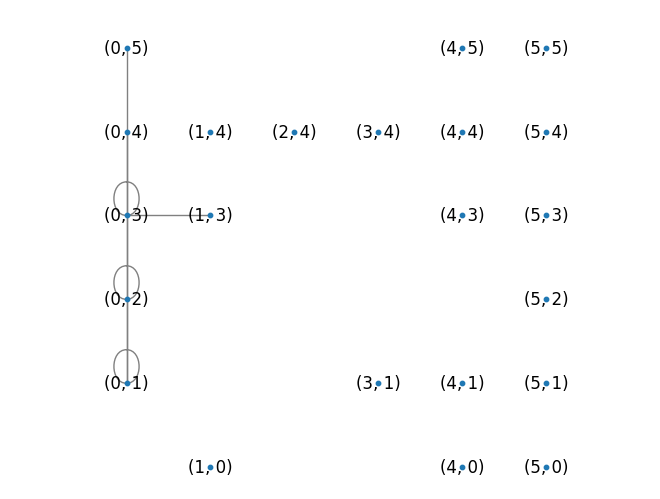

In [62]:
s,b = get_coords(sites,bonds)
plot_solution(s,b,n)

In [63]:
corners
c_cord = [[coords(a,n),coords(b,n),coords(c,n)] for a,b,c in corners]

In [64]:
c_cord

[[(0, 0), (1, 0), (1, 1)],
 [(1, 4), (0, 4), (0, 3)],
 [(1, 4), (0, 4), (0, 5)],
 [(1, 5), (1, 4), (1, 3)],
 [(2, 0), (1, 0), (0, 0)],
 [(2, 0), (1, 0), (1, 1)],
 [(2, 1), (3, 1), (3, 2)],
 [(2, 2), (3, 2), (3, 3)],
 [(2, 2), (1, 2), (1, 1)],
 [(2, 2), (1, 2), (1, 3)],
 [(2, 3), (2, 2), (2, 1)],
 [(2, 3), (3, 3), (3, 4)],
 [(2, 3), (1, 3), (1, 2)],
 [(2, 4), (1, 4), (1, 3)],
 [(2, 4), (2, 3), (2, 2)],
 [(2, 4), (3, 4), (3, 3)],
 [(3, 0), (2, 0), (1, 0)],
 [(3, 1), (2, 1), (2, 0)],
 [(3, 1), (2, 1), (2, 2)],
 [(3, 1), (2, 1), (1, 1)],
 [(3, 1), (4, 1), (4, 0)],
 [(0, 1), (1, 1), (1, 0)],
 [(0, 1), (1, 1), (1, 2)],
 [(3, 2), (2, 2), (2, 1)],
 [(3, 2), (2, 2), (2, 3)],
 [(3, 2), (3, 1), (3, 0)],
 [(3, 2), (4, 2), (4, 1)],
 [(3, 2), (4, 2), (4, 3)],
 [(3, 3), (2, 3), (2, 2)],
 [(3, 3), (2, 3), (1, 3)],
 [(3, 4), (2, 4), (1, 4)],
 [(3, 4), (2, 4), (2, 5)],
 [(3, 4), (3, 3), (3, 2)],
 [(3, 4), (4, 4), (4, 5)],
 [(3, 5), (4, 5), (4, 4)],
 [(4, 0), (3, 0), (3, 1)],
 [(4, 1), (3, 1), (3, 0)],
 

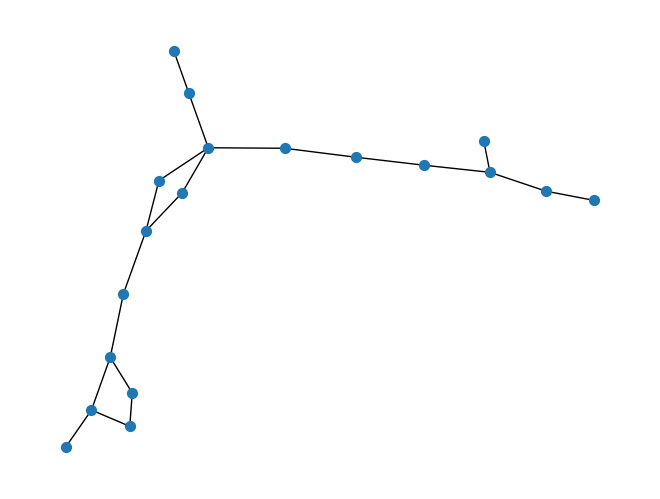

In [66]:
import matplotlib.pyplot as plt
import networkx as nx

def show_graph_with_labels(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=50,)
    plt.show()

show_graph_with_labels(adjacency_matrix)